In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

### 📖 Cell 1: Loading the Stanford Dogs Dataset

We start by loading the Stanford Dogs dataset and splitting it into training, validation, and test sets. Each image is paired with its label, and we gather key dataset info like the number of dog breeds. We also set important parameters: image size (299x299) and batch size (32). This prepares our data for the upcoming steps in model training.


In [3]:
# 1. Load the Stanford Dogs dataset
(train_ds, val_ds, test_ds), ds_info = tfds.load(
    'stanford_dogs',
    split=['train[:85%]', 'train[85%:]', 'test'],
    as_supervised=True,
    with_info=True
)

NUM_CLASSES = ds_info.features['label'].num_classes
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32

### 🧼 Cell 2: Preprocessing the Images

Before feeding images to our model, we need to prepare them properly. This function resizes each image to the target size (299x299) and applies preprocessing specific to the InceptionV3 model. This ensures the input images are in the right format and scale for efficient learning.

In [4]:
# 2. Preprocessing functions
def preprocess(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, label


### 🎨 Cell 3: Augmenting the Images

To help the model generalize better, we apply data augmentation. This function randomly flips images, adjusts brightness and contrast, and then resizes and preprocesses them just like before. These small random changes simulate new data, making the model more robust.


In [5]:
# 3. Augmentation function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, label

### 🧪 Cell 4: Preparing the Datasets for Training

Now we apply our preprocessing and augmentation to the data. We create two training datasets:

- `train_ds_no_aug`: Preprocessed but **not augmented**, for baseline training.
- `train_ds_aug`: Includes **data augmentation**, helping the model generalize.

The validation and test datasets are only preprocessed (no augmentation) to ensure consistent and fair evaluation. All datasets are batched, shuffled (where appropriate), and optimized with prefetching for efficient training.


In [6]:
# 4. Apply preprocessing
train_ds_no_aug = train_ds.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_ds_aug = train_ds.map(augment).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### 🏗️ Cell 5: Building the Model with InceptionV3

We build our model using **InceptionV3** as the base, a powerful pre-trained convolutional neural network. The base model is loaded without its top layers and frozen initially to retain its learned features.

We then add:
- A global average pooling layer to reduce dimensions,
- A dropout layer to prevent overfitting,
- And a final dense layer with softmax activation to classify images into one of the dog breeds.

The function returns both the full model and the base model for future fine-tuning.


In [7]:
# 5. Build the model
def build_model():
    base_model = InceptionV3(include_top=False, input_shape=IMAGE_SIZE + (3,), weights='imagenet')
    base_model.trainable = False  # Freeze base initially

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

### 🏋️ Cell 6: Compiling and Training the Model

This function handles training our model in two phases:

1. **Initial Training**: The model is compiled with the Adam optimizer and trained for up to 15 epochs. Early stopping is used to halt training if the validation loss doesn’t improve for 3 epochs, helping prevent overfitting.

2. **Optional Fine-Tuning**: If `fine_tune=True`, we unfreeze the base model (e.g., InceptionV3) to allow further training on its layers. This gives the model a chance to adapt more deeply to our specific dataset. Training is then continued with a lower learning rate for a few more epochs.

The function returns the trained model and its training history.


In [8]:
# 6. Compile & train function
def compile_and_train(model, train_data, val_data, fine_tune=False, base_model=None):
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=15,
        callbacks=[early_stop]
    )

    # Optional: fine-tune top layers
    if fine_tune and base_model:
        base_model.trainable = True
        model.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history_fine = model.fit(
            train_data,
            validation_data=val_data,
            epochs=5,
            callbacks=[early_stop]
        )
        return model, history_fine

    return model, history

### 🚀 Cell 7: Training Both Models

In this step, we train two separate models:

1. **Model without Augmentation**: We build and train a model using the preprocessed data (without augmentation), and fine-tune it by unfreezing the base model.
   
2. **Model with Augmentation**: We repeat the process but this time using the augmented data, allowing the model to learn from more varied images.

Both models are trained with early stopping and fine-tuning.

In [9]:
# 7. Train both models
model_no_aug, base_no_aug = build_model()
model_no_aug, history_no_aug = compile_and_train(model_no_aug, train_ds_no_aug, val_ds, fine_tune=True, base_model=base_no_aug)

model_aug, base_aug = build_model()
model_aug, history_aug = compile_and_train(model_aug, train_ds_aug, val_ds, fine_tune=True, base_model=base_aug)

Epoch 1/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 97s 231ms/step - accuracy: 0.1104 - loss: 4.4053 - val_accuracy: 0.7550 - val_loss: 2.7429
Epoch 2/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 48s 143ms/step - accuracy: 0.6715 - loss: 2.4656 - val_accuracy: 0.8533 - val_loss: 1.4964
Epoch 3/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 47s 141ms/step - accuracy: 0.8211 - loss: 1.3757 - val_accuracy: 0.8789 - val_loss: 0.9321
Epoch 4/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 48s 141ms/step - accuracy: 0.8628 - loss: 0.9004 - val_accuracy: 0.8917 - val_loss: 0.6803
Epoch 5/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 47s 139ms/step - accuracy: 0.8713 - loss: 0.6779 - val_accuracy: 0.8961 - val_loss: 0.5516
Epoch 6/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 83s 145ms/step - accuracy: 0.8907 - loss: 0.5489 - val_accuracy: 0.8972 - val_loss: 0.4800
Epoch 7/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 81s 142ms/step - accuracy: 0.8997 - loss: 0.4671 - val_accuracy: 0.9011 - val_loss: 0.4296
Epoch 8/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 51s 154ms/step - accuracy: 0.9015 - loss: 0

### 📊 Cell 8: Evaluating the Models

After training, we evaluate both models:

- For each model (with and without augmentation), we extract the training loss, training accuracy, validation loss, and validation accuracy from the training history.
- We then assess the models on the test dataset to check how well they generalize.

This helps us compare how augmentation impacts performance and ensures that our models are not overfitting to the training data.

In [10]:
# 8. Evaluate
train_loss_no_aug = history_no_aug.history['loss'][-1]
train_acc_no_aug = history_no_aug.history['accuracy'][-1]
val_loss_no_aug = history_no_aug.history['val_loss'][-1]
val_acc_no_aug = history_no_aug.history['val_accuracy'][-1]
test_loss_no_aug, test_acc_no_aug = model_no_aug.evaluate(test_ds)

train_loss_aug = history_aug.history['loss'][-1]
train_acc_aug = history_aug.history['accuracy'][-1]
val_loss_aug = history_aug.history['val_loss'][-1]
val_acc_aug = history_aug.history['val_accuracy'][-1]
test_loss_aug, test_acc_aug = model_aug.evaluate(test_ds)

269/269 ━━━━━━━━━━━━━━━━━━━━ 38s 140ms/step - accuracy: 0.8973 - loss: 0.3247
269/269 ━━━━━━━━━━━━━━━━━━━━ 33s 121ms/step - accuracy: 0.8981 - loss: 0.3149


### 📊 Cell 9: Visualizing Training and Validation Performance

To better understand how each model performed, we visualize key metrics across the epochs:

1. **Figure 1: Train Loss** – We compare the training loss for both the model with and without data augmentation.
2. **Figure 2: Validation Loss** – We plot the validation loss to see how each model generalizes.
3. **Figure 3: Train Accuracy** – This shows the accuracy achieved by both models during training.
4. **Figure 4: Validation Accuracy** – We visualize the accuracy on the validation set to see how well each model performs on unseen data.

These graphs give us a clear picture of the models' learning curves and how augmentation influences performance.


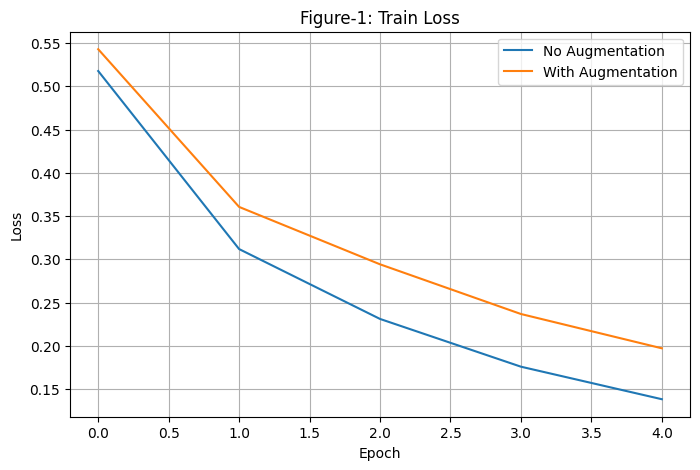

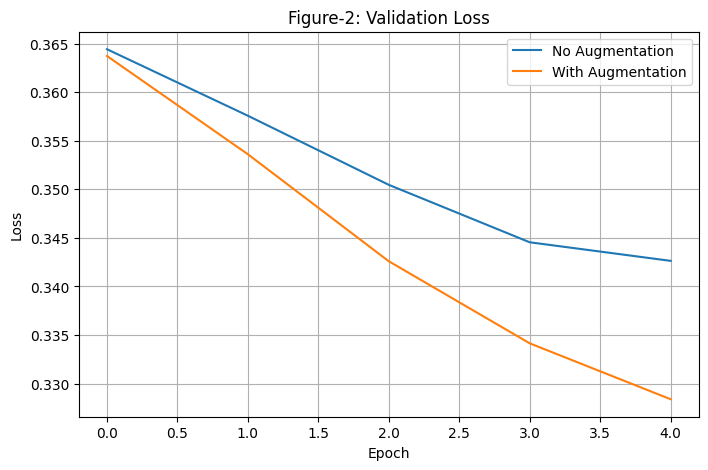

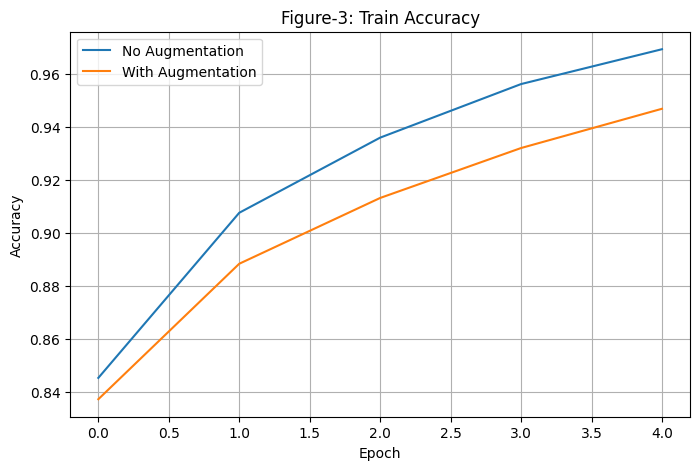

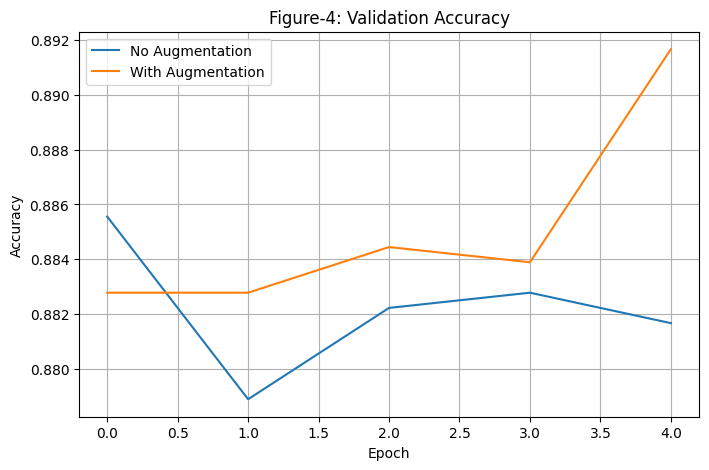

In [11]:
# Figure-1: Train Loss for both models
plt.figure(figsize=(8, 5))
plt.plot(history_no_aug.history['loss'], label='No Augmentation')
plt.plot(history_aug.history['loss'], label='With Augmentation')
plt.title('Figure-1: Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Figure-2: Validation Loss for both models
plt.figure(figsize=(8, 5))
plt.plot(history_no_aug.history['val_loss'], label='No Augmentation')
plt.plot(history_aug.history['val_loss'], label='With Augmentation')
plt.title('Figure-2: Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Figure-3: Train Accuracy for both models
plt.figure(figsize=(8, 5))
plt.plot(history_no_aug.history['accuracy'], label='No Augmentation')
plt.plot(history_aug.history['accuracy'], label='With Augmentation')
plt.title('Figure-3: Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Figure-4: Validation Accuracy for both models
plt.figure(figsize=(8, 5))
plt.plot(history_no_aug.history['val_accuracy'], label='No Augmentation')
plt.plot(history_aug.history['val_accuracy'], label='With Augmentation')
plt.title('Figure-4: Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
results = pd.DataFrame({
    "Model": ["Pretrained_no_aug", "Pretrained_aug"],
    "Train Loss": [train_loss_no_aug, train_loss_aug],
    "Train Accuracy": [train_acc_no_aug, train_acc_aug],
    "Validation Loss": [val_loss_no_aug, val_loss_aug],
    "Validation Accuracy": [val_acc_no_aug, val_acc_aug],
    "Test Loss": [test_loss_no_aug, test_loss_aug],
    "Test Accuracy": [test_acc_no_aug, test_acc_aug]
})

print("\n📊 Final Results Table:")
print(results.to_string(index=False))


📊 Final Results Table:
            Model  Train Loss  Train Accuracy  Validation Loss  Validation Accuracy  Test Loss  Test Accuracy
Pretrained_no_aug    0.138355        0.969314         0.342636             0.881667   0.331963       0.895105
   Pretrained_aug    0.197190        0.946863         0.328382             0.891667   0.320064       0.895455


### 📊 Final Results Table

| Model             | Train Loss | Train Accuracy | Validation Loss | Validation Accuracy | Test Loss | Test Accuracy |
|-------------------|------------|----------------|------------------|----------------------|-----------|----------------|
| Pretrained_no_aug | 0.138355   | 0.969314       | 0.342636         | 0.881667             | 0.331963  | 0.895105       |
| Pretrained_aug    | 0.197190   | 0.946863       | 0.328382         | 0.891667             | 0.320064  | 0.895455       |
